In [1]:
! git clone https://github.com/hugothimonier/HOTT_NLP_ENSAE.git

Cloning into 'HOTT_NLP_ENSAE'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 130 (delta 2), reused 6 (delta 2), pack-reused 123
Receiving objects: 100% (130/130), 361.42 MiB | 21.25 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Checking out files: 100% (42/42), done.


In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2020-04-12 08:29:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-12 08:29:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-12 08:29:37--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [3]:
import os 
import numpy as np
import pandas as pd
import glob
import os

!pip install pot
from HOTT_NLP_ENSAE.knn_classifier import knn, knn2, calculate_matrix_dist
from HOTT_NLP_ENSAE.data import load_data, transform_dataframe, gen_data, reduce_vocab
from HOTT_NLP_ENSAE.hott import hott

from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from scipy import sparse 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE 

import re
import time

from sklearn.decomposition import LatentDirichletAllocation as lda
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from collections import Counter
import itertools

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

%matplotlib inline

import sys
sys.setrecursionlimit(10**5)


     |████████████████████████████████| 307kB 2.8MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 38.5MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=48c61c5f005cbd62b977f5ee126d8ca28ab9916bc13d171617045c9df4c4b879
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=0aa9b54a1ec03571f3920a7f2c34364ce6ad6bc469657ccbeb73f3d22c6acea5
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Load data 
data_path_1 = 'HOTT_NLP_ENSAE/NYT_dataset/CommentsApril2018_1.csv'
data_path_2 = 'HOTT_NLP_ENSAE/NYT_dataset/CommentsApril2018_2.csv'

df1=pd.read_csv(data_path_1, encoding = 'latin1')
df2=pd.read_csv(data_path_2, encoding = 'latin1')
df2 = df2.reset_index(drop=True)
df = pd.concat([df1, df2], axis=0)

embed_path = 'glove.6B.300d.txt'

# Statistics on dataset NYT comments

In [5]:
unique, counts = np.unique(df['newDesk'], return_counts = True)
print('There are %s categories in the dataset to predict.'%(len(unique)),
      '\nThe average number of document belonging to the different categories is %s.'%(np.round(np.mean(counts),0),),
      '\nThe maximum is %s and the minimum is %s.'%( np.max(counts), np.min(counts)))

There are 39 categories in the dataset to predict. 
The average number of document belonging to the different categories is 6793.0. 
The maximum is 84665 and the minimum is 6.


## Heuristic on documents before stemming

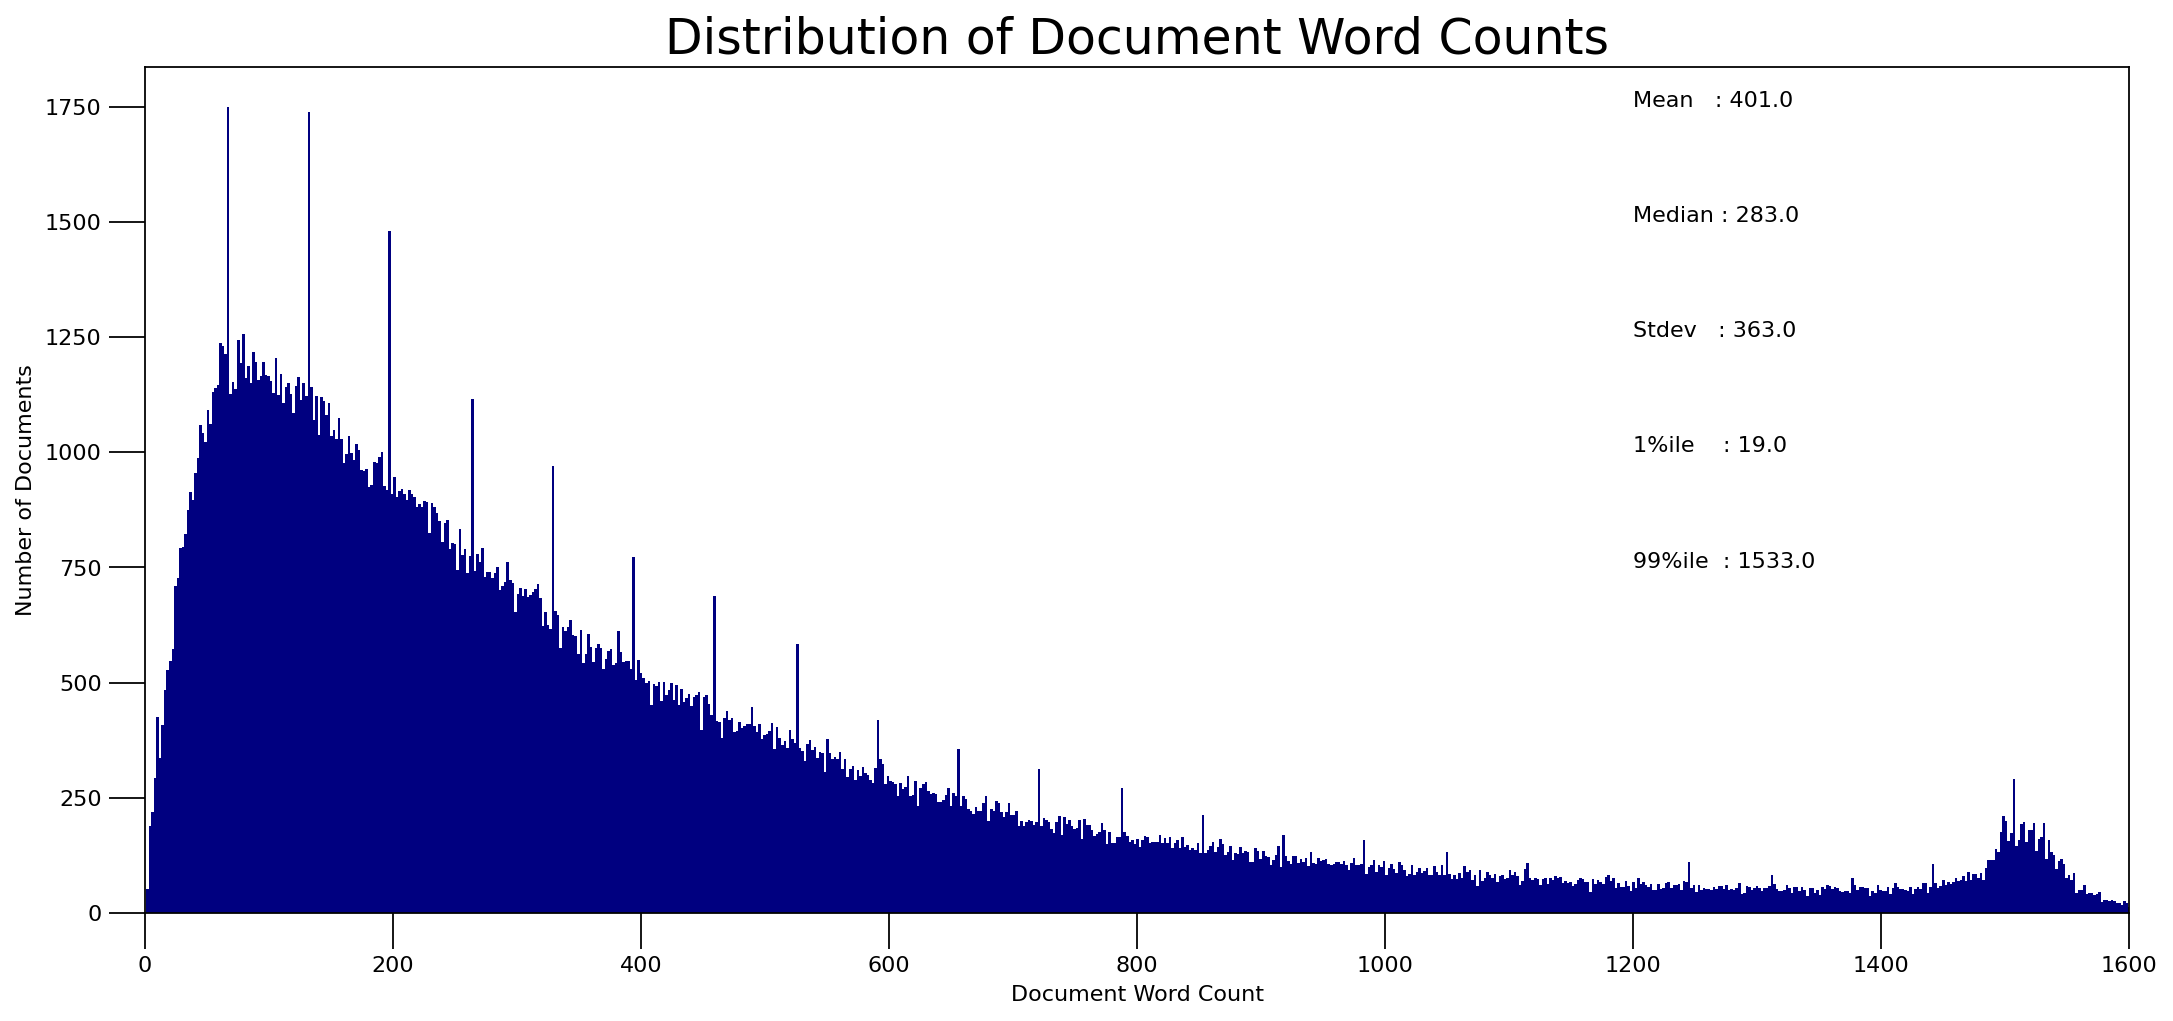

In [6]:
doc_lens = [len(d) for d in df.commentBody]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(1200, 1750, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(1200, 1500, "Median : " + str(round(np.median(doc_lens))))
plt.text(1200, 1250, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(1200, 1000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(1200, 750, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1600), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1600,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.savefig('distrib_wc_before.png', dpi = 160)
plt.show()

In [7]:
k = 20
stemming_ = True 
p_ = 1
n_word_keep_ = 20

# dataloading, #create reduced balance dataframe for LDA
data = load_data(df, embed_path, stemming = stemming_, K = k, p = p_, n_word_keep = n_word_keep_, balance = True, cat_freq = 200)


100% (400000 of 400000) |################| Elapsed Time: 0:00:21 Time:  0:00:21


extraction done in 24.962s.
stemming
The vocabulary has been reduced from 22220 words to 6257 words. This represents a reduction of 71.84 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

## Heuristic on documents after stemming

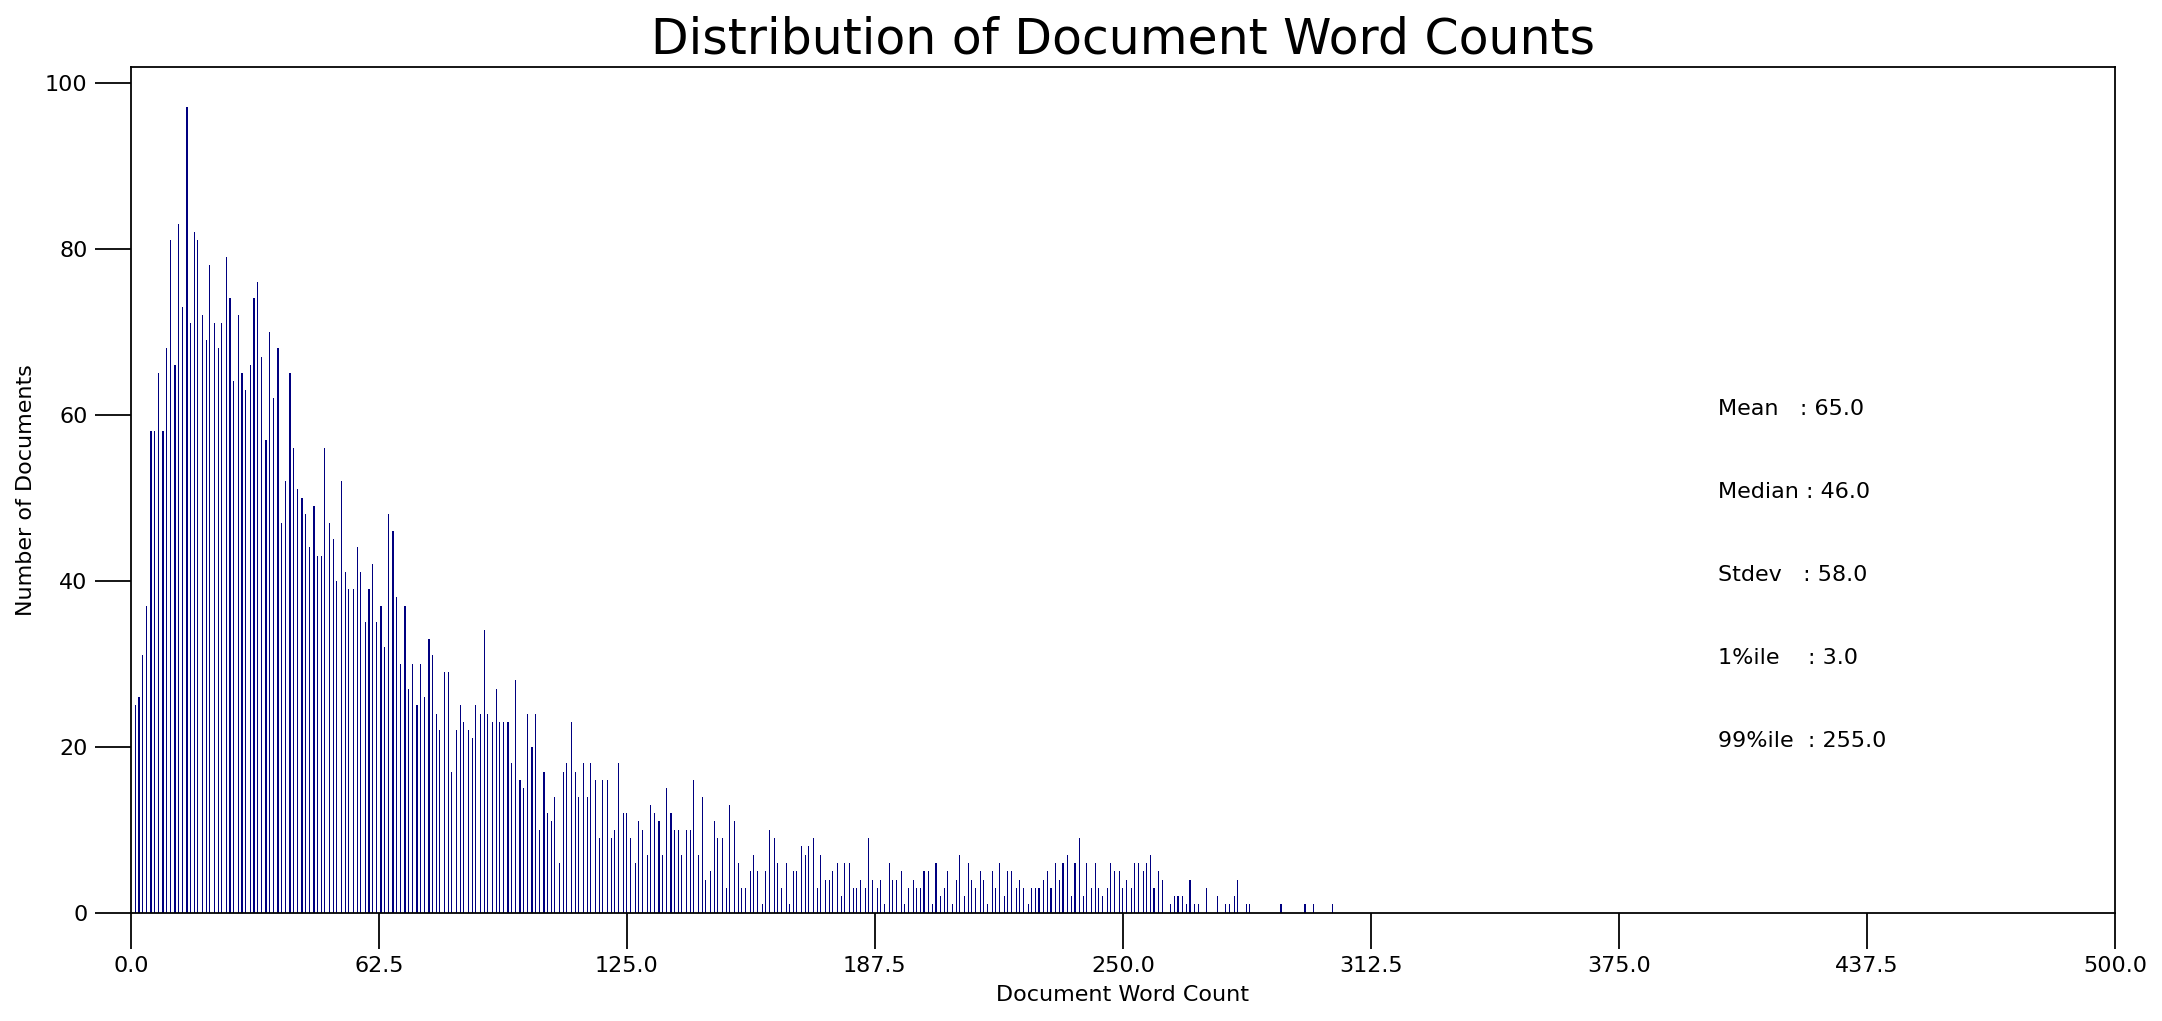

In [8]:
doc_lens = [len(d) for d in data['text']]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(400, 60, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(400,  50, "Median : " + str(round(np.median(doc_lens))))
plt.text(400,  40, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(400,  30, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(400,  20, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,500,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.savefig('distrib_wc_after.png', dpi = 160)
plt.show()

In [9]:
voc, y = data["text"], data["y"]
sent_topics_df = pd.DataFrame()
for i, row_list in enumerate(data['proportions']):
    max_proportion = np.amax(row_list)
    idx_max_topic = np.where(row_list == max_proportion)[0][0]
    sent_topics_df = sent_topics_df.append(pd.Series([int(idx_max_topic), round(max_proportion,4), data['topic_words'][idx_max_topic]]), ignore_index=True)

sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
sent_topics_df["Text"] = voc
del voc, y

sent_topics_df.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,1.0,0.0951,"[would, articl, read, stori, job, book, friend...","[thank, you, for, this, mr, wells, nicely, don..."
1,17.0,0.1715,"[one, place, live, wonder, hous, said, someon,...","[smithiei, completely, agree, with, you, i, en..."
2,7.0,0.1335,"[trump, presid, republican, polit, vote, elect...","[trump, called, so, rand, paul, changed, his, ..."
3,7.0,0.0799,"[trump, presid, republican, polit, vote, elect...",[evidently]
4,7.0,0.2068,"[trump, presid, republican, polit, vote, elect...","[and, isnt, it, a, bit, ironic, that, these, s..."
5,7.0,0.1204,"[trump, presid, republican, polit, vote, elect...","[no, hes, not, the, cause, hes, the, effectof,..."
6,7.0,0.2799,"[trump, presid, republican, polit, vote, elect...","[okay, so, these, voters, went, for, trump, be..."
7,7.0,0.1959,"[trump, presid, republican, polit, vote, elect...","[despite, an, attempt, by, the, democratic, pa..."
8,7.0,0.2105,"[trump, presid, republican, polit, vote, elect...","[i, never, bought, that, economic, explanation..."
9,7.0,0.2182,"[trump, presid, republican, polit, vote, elect...","[there, is, strong, evidence, that, gender, bi..."


## Most representative sentence of each topic

In [10]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = sent_topics_df.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.4975,"[time, didnt, old, yes, use, kill, polic, sinc...","[as, horrible, as, the, death, was, on, this, ..."
1,1.0,0.3408,"[would, articl, read, stori, job, book, friend...","[why, would, i, drain, the, meat, and, then, a..."
2,2.0,0.4901,"[new, like, come, back, say, best, year, far, ...","[the, headline, says, it, all, about, the, sta..."
3,3.0,0.4589,"[look, two, may, gun, like, one, last, guy, ha...","[controlled, chaos, a, perfect, descriptioni, ..."
4,4.0,0.5440,"[school, pay, money, educ, student, tax, publi...","[i, hope, our, public, school, teachers, here,..."
5,5.0,0.3938,"[work, good, thing, mean, tri, give, understan...","[in, europe, they, require, a, pin, rather, th..."
6,6.0,0.3794,"[women, alway, issu, happen, got, interest, me...","[i, noticed, i, read, the, 14, april, nyt, art..."
7,7.0,0.5783,"[trump, presid, republican, polit, vote, elect...","[historical, false, equivalency, americans, sa..."
8,8.0,0.4475,"[countri, world, continu, histori, war, contro...","[israel, has, always, maintained, the, right, ..."
9,9.0,0.3178,"[life, famili, white, first, man, might, other...","[mrs, bush, walked, the, walk, and, talked, th..."


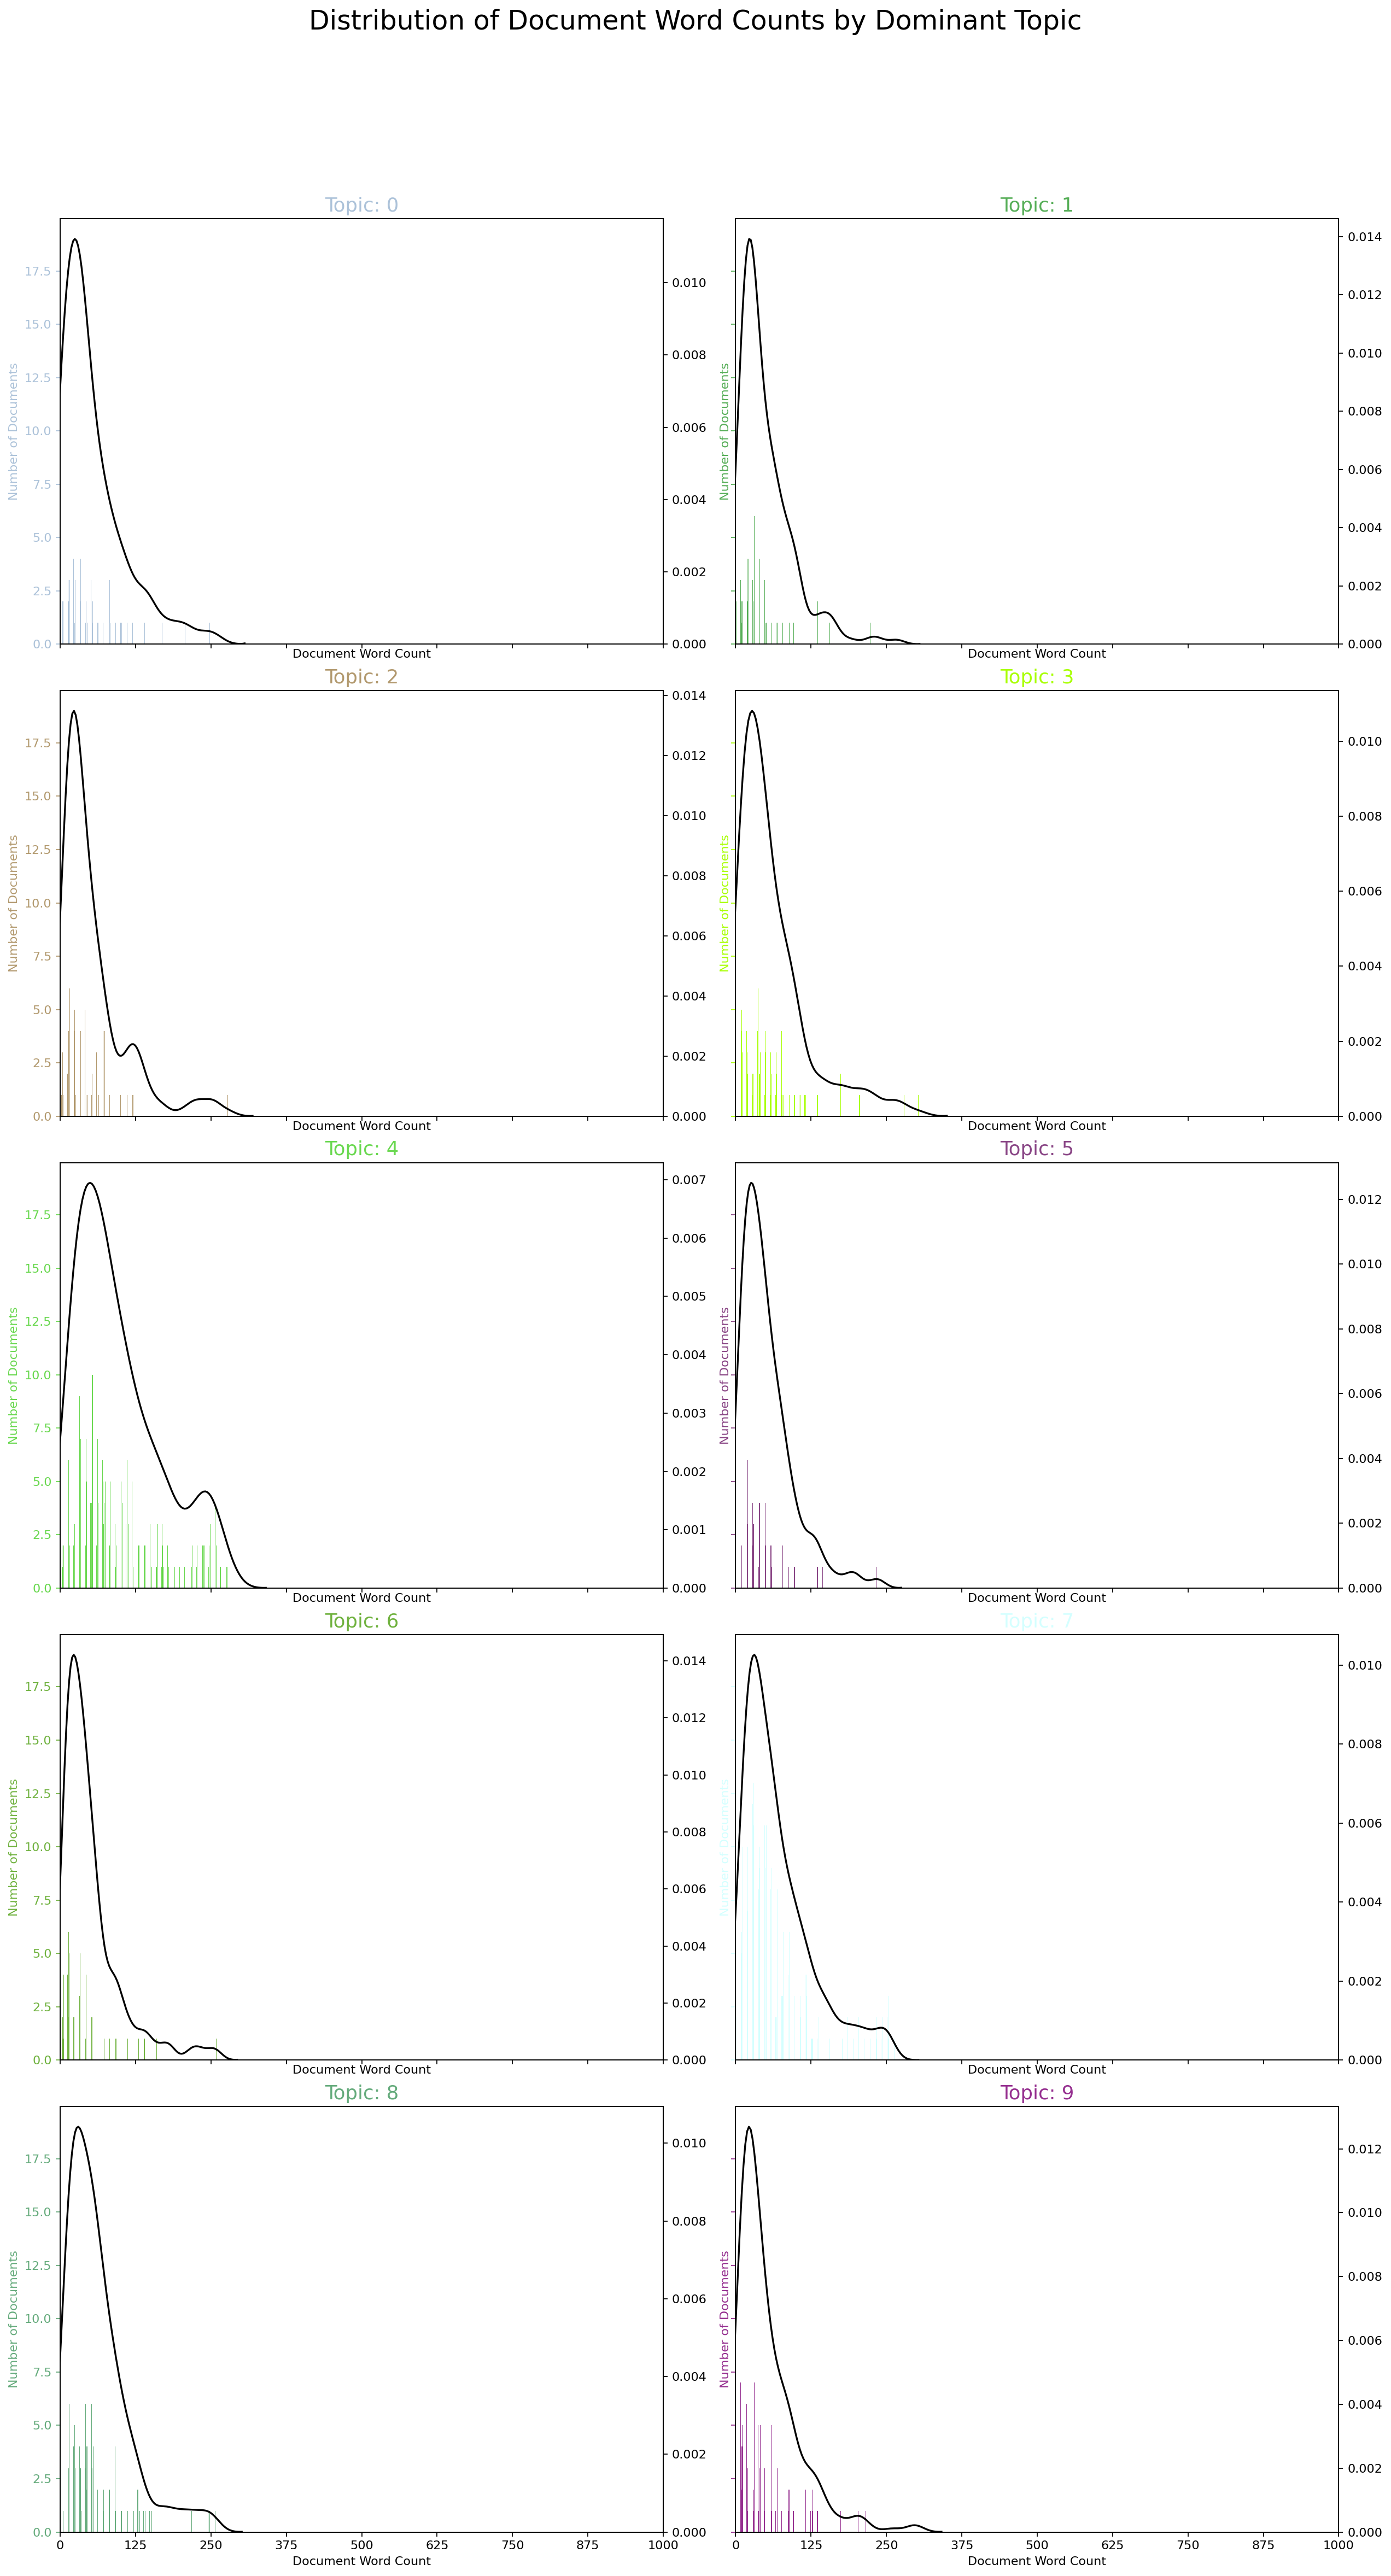

In [11]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,30), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = sent_topics_df.loc[sent_topics_df.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub['Text']]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.savefig('word_distrib_topics.png')
plt.show()

In [0]:
bow_train, bow_test, topic_train, topic_test, y_train, y_test = train_test_split(data['X'],
                                                                                 data['proportions'],
                                                                                 data['y'],
                                                                                 random_state= 0)
y_train = y_train.ravel()
y_test = y_test.ravel()
C = data['cost_T']

# Analysis with all the categories given in the database

## Hyper-parameters tuning

In [1]:
K = [10,15,20,25,30,35,40,45,50,55,60,65,70]
test_error_ = dict()

for k in K:
    print(k)
    # dataloading
    data = load_data(df, embed_path, stemming = stemming_, K = k, p = p_, n_word_keep = n_word_keep_, balance = False)
    bow_train, bow_test, topic_train, topic_test, y_train, y_test = train_test_split(data['X'],
                                                                                 data['proportions'],
                                                                                 data['y'],
                                                                                 random_state= 0)
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    C = data['cost_T']
       
    print("find neigbours")
    test_error = dict()
    
    #calcul of the matrix for 
    mat=calculate_matrix_dist(topic_train,topic_test,hott,C)
    
    for neigh in np.arange(7, 100, 2):
        #hott_test_error, hott_pred = knn(topic_train, topic_test, y_train, y_test, hott, C, n_neighbors=neigh)
        hott_test_error, hott_pred = knn2(mat, y_train, y_test, n_neighbors=neigh)
        test_error[neigh] = hott_test_error
        print('Pour un %s topics et un nombre de voisin égal à %s l\'erreur sur la base de test est de l\'ordre de %s'%(k,neigh,hott_test_error))
    test_error_[k] = test_error

cols = [color for name, color in mcolors.XKCD_COLORS.items()] 

plt.style.use('seaborn')
for k in [10,15,20,25,30,35,40,45,50,55,60,65,70] :
    plt.plot(list(test_error_[k].keys()), list(test_error_[k].values()), label = str(k)+' LDA Topics', c = cols[k])

plt.ylabel('Test error', fontsize = 14)
plt.xlabel('Number of neighbours', fontsize = 14)
plt.suptitle('Learning curves for the Knn classifier using the Hott metric', fontsize = 12, y = 1.03)
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig('drive/My Drive/error_rate.png')

10


NameError: ignored

## Best model analysis

In [71]:
#Best model : number topics LDA 20, number neigbours = 37

df1=pd.read_csv(data_path_1, encoding = 'latin1')
df2=pd.read_csv(data_path_2, encoding = 'latin1')
df2 = df2.reset_index(drop=True)
df = pd.concat([df1, df2], axis=0)

data = load_data(df, embed_path, stemming = stemming_, K = 20, p = p_, n_word_keep = n_word_keep_, balance = True, cat_freq=150)
bow_train, bow_test, topic_train, topic_test, y_train, y_test = train_test_split(data['X'],
                                                                                 data['proportions'],
                                                                                 data['y'],
                                                                               random_state= 0)
mat=calculate_matrix_dist(topic_train,topic_test,hott,C)
                                                                             
y_train = y_train.ravel()
y_test = y_test.ravel()
C = data['cost_T']
       
hott_test_error, hott_pred = knn2(mat, y_train, y_test, n_neighbors= 37)
      

100% (400000 of 400000) |################| Elapsed Time: 0:00:21 Time:  0:00:21


extraction done in 23.664s.
stemming
The vocabulary has been reduced from 19605 words to 5471 words. This represents a reduction of 72.09 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 2

100% (1102 of 1102) |####################| Elapsed Time: 0:03:30 Time:  0:03:30


### Confusion Matrix

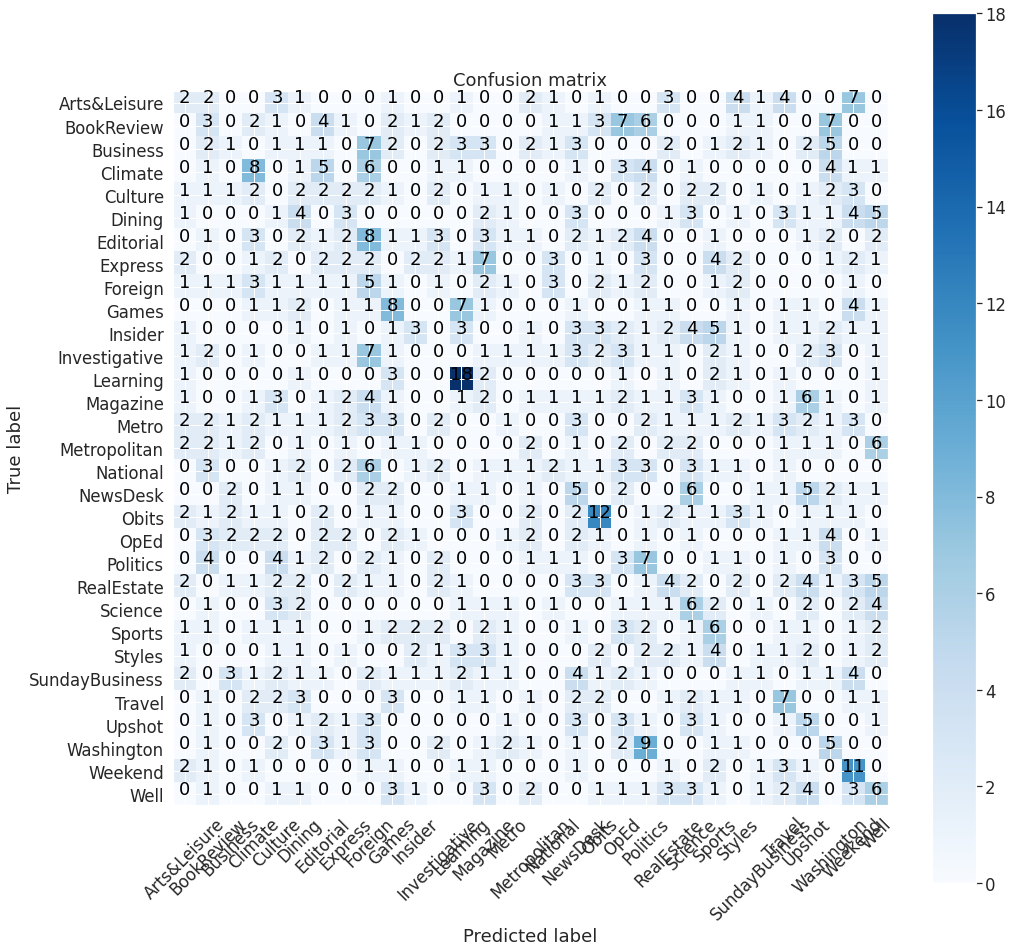

In [72]:

cm = confusion_matrix(y_test , hott_pred)
classes= ['Arts&Leisure','BookReview','Business','Climate','Culture','Dining','Editorial',
 'Express','Foreign','Games','Insider','Investigative','Learning','Magazine','Metro','Metropolitan',
 'National','NewsDesk','Obits','OpEd','Politics','RealEstate','Science','Sports','Styles',
 'SundayBusiness','Travel','Upshot','Washington', 'Weekend','Well']
title='Confusion matrix'
cmap=plt.cm.Blues
fig = plt.figure(figsize=(16,16))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.tight_layout()
plt.xlim(-0.5, len(classes)-0.5)
plt.ylim(len(classes)-0.5, -0.5)


plt.show()


### TSNE

In [0]:

## WARNING THE COMPUTATION TIME ON COLAB IS LONG (5~10 minuts)
def cust_hott(p,q):
    return hott(p, q, C, threshold=None)

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
  
from sklearn.manifold import TSNE 
#print("build TSNE")
Xtsne = pd.DataFrame(TSNE(n_components=2, metric = cust_hott,verbose=0).fit_transform(data['proportions']), columns = ['col1','col2'])
Xtsne['hue_'] = data['lib']


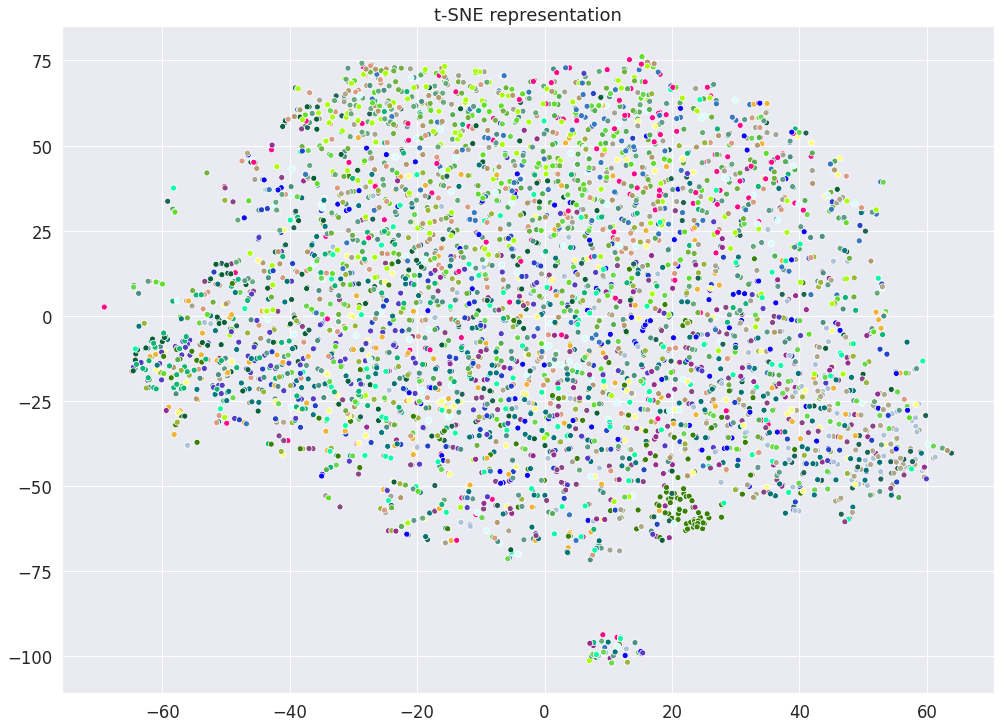

In [78]:

cols = [color for name, color in mcolors.XKCD_COLORS.items()] 
colors = {}
for y_ in np.unique(data['y']) :
    colors[y_] = cols[y_+1]
colors={theme : c for theme, c in zip(np.unique(data["lib"]), colors.values())}

Xtsne.rename(columns={'hue_': 'Categories'}, inplace=True)

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(16.7, 12.27)
sns_plot = sns.scatterplot('col1','col2', data = Xtsne, hue = 'Categories', palette = colors, legend = False)
sns_plot.set_title("t-SNE representation")
sns_plot.set(xlabel='', ylabel='')
fig_ = sns_plot.get_figure()


# Analysis with 7 New Desk categories arbitrary chosen 

In [16]:
df1=pd.read_csv(data_path_1, encoding = 'latin1')
df2=pd.read_csv(data_path_2, encoding = 'latin1')
df2 = df2.reset_index(drop=True)
df = pd.concat([df1, df2], axis=0)

df3=df[df.newDesk.isin(["Sports","Climate","Games","Arts&Leisure","Science","Dining","Foreign"])]
Counter(df3.newDesk)

Counter({'Arts&Leisure': 497,
         'Climate': 3885,
         'Dining': 1722,
         'Foreign': 15149,
         'Games': 3875,
         'Science': 3517,
         'Sports': 3240})

## Hyper-parameters tuning

In [15]:
K = [10,15,20,25,30,35,40,45,50,55,60,65,70]
test_error_ = dict()

for k in K:
    print(k)
    # dataloading
    data = load_data(df3, embed_path, stemming = stemming_, K = k, p = p_, n_word_keep = n_word_keep_, balance = True, cat_freq= 500)
    bow_train, bow_test, topic_train, topic_test, y_train, y_test = train_test_split(data['X'],
                                                                                 data['proportions'],
                                                                                 data['y'],
                                                                                 random_state= 0)
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    C = data['cost_T']
       
    print("find neigbours")
    test_error = dict()
    
    #calcul of the matrix for 
    mat=calculate_matrix_dist(topic_train,topic_test,hott,C)
    
    for neigh in np.arange(7, 100, 2):
        #hott_test_error, hott_pred = knn(topic_train, topic_test, y_train, y_test, hott, C, n_neighbors=neigh)
        hott_test_error, hott_pred = knn2(mat, y_train, y_test, n_neighbors=neigh)
        test_error[neigh] = hott_test_error
        print('Pour un %s topics et un nombre de voisin égal à %s l\'erreur sur la base de test est de l\'ordre de %s'%(k,neigh,hott_test_error))
    test_error_[k] = test_error


 13% (107 of 778) |###                   | Elapsed Time: 0:00:13 ETA:   0:01:25

KeyboardInterrupt: ignored

In [0]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()] 

plt.style.use('seaborn')
for k in [10,15,20,25,30,35,40,45,50,55,60,65,70] :
    plt.plot(list(test_error_[k].keys()), list(test_error_[k].values()), label = str(k)+' LDA Topics', c = cols[k])

plt.ylabel('Test error', fontsize = 14)
plt.xlabel('Number of neighbours', fontsize = 14)
plt.suptitle('Learning curves for the Knn classifier using the Hott metric', fontsize = 12, y = 1.03)
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
#plt.savefig('drive/My Drive/error_rate_7.png')

## Best model analysis

In [67]:
#Best model : number topics LDA 20, number neigbours = 37

df1=pd.read_csv(data_path_1, encoding = 'latin1')
df2=pd.read_csv(data_path_2, encoding = 'latin1')
df2 = df2.reset_index(drop=True)
df = pd.concat([df1, df2], axis=0)

df3=df[df.newDesk.isin(["Sports","Climate","Games","Arts&Leisure","Science","Dining","Foreign"])]
print(Counter(df3.newDesk))

data = load_data(df3, embed_path, stemming = stemming_, K = 20, p = p_, n_word_keep = n_word_keep_, balance = True, cat_freq=500)
bow_train, bow_test, topic_train, topic_test, y_train, y_test = train_test_split(data['X'],
                                                                                 data['proportions'],
                                                                                 data['y'],
                                                                               random_state= 0)
mat=calculate_matrix_dist(topic_train,topic_test,hott,C)
                                                                             
y_train = y_train.ravel()
y_test = y_test.ravel()
C = data['cost_T']
       
hott_test_error, hott_pred = knn2(mat, y_train, y_test, n_neighbors= 37)
      

Counter({'Foreign': 15149, 'Climate': 3885, 'Games': 3875, 'Science': 3517, 'Sports': 3240, 'Dining': 1722, 'Arts&Leisure': 497})


100% (400000 of 400000) |################| Elapsed Time: 0:00:21 Time:  0:00:21


extraction done in 23.578s.
stemming
The vocabulary has been reduced from 15875 words to 4222 words. This represents a reduction of 73.4 percent
computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28

100% (778 of 778) |######################| Elapsed Time: 0:01:42 Time:  0:01:42


### Confusion matrix 


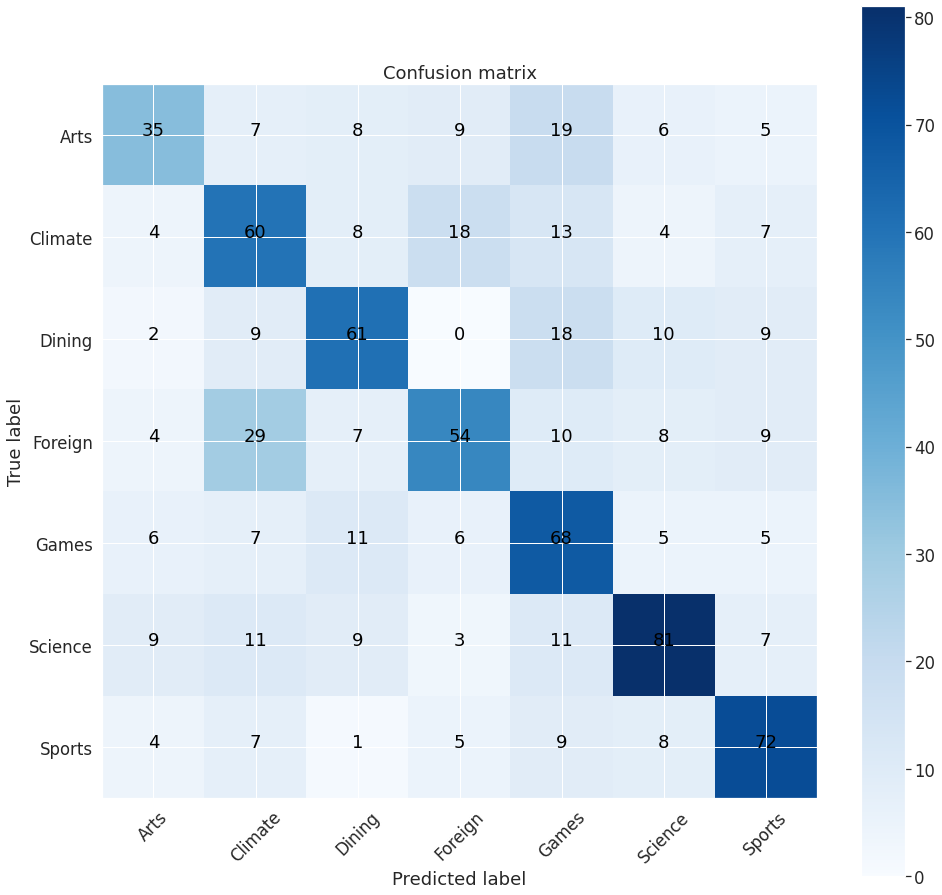

In [69]:
cm = confusion_matrix(y_test , hott_pred)
classes=['Arts','Climate','Dining','Foreign','Games','Science','Sports']
title='Confusion matrix'
cmap=plt.cm.Blues

fig = plt.figure(figsize=(16,16))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.tight_layout()
plt.xlim(-0.5, len(classes)-0.5)
plt.ylim(len(classes)-0.5, -0.5)


plt.show()


### TSNE 

build TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3119 samples in 1.221s...
[t-SNE] Computed neighbors for 3119 samples in 530.797s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3119
[t-SNE] Computed conditional probabilities for sample 2000 / 3119
[t-SNE] Computed conditional probabilities for sample 3000 / 3119
[t-SNE] Computed conditional probabilities for sample 3119 / 3119
[t-SNE] Mean sigma: 0.473035
[t-SNE] Computed conditional probabilities in 0.175s
[t-SNE] Iteration 50: error = 84.2467728, gradient norm = 0.0144387 (50 iterations in 2.872s)
[t-SNE] Iteration 100: error = 83.7237549, gradient norm = 0.0033647 (50 iterations in 2.132s)
[t-SNE] Iteration 150: error = 83.6262054, gradient norm = 0.0004299 (50 iterations in 1.360s)
[t-SNE] Iteration 200: error = 83.5944977, gradient norm = 0.0001404 (50 iterations in 1.441s)
[t-SNE] Iteration 250: error = 83.5879211, gradient norm = 0.0000923 (50 iterations in 1.604s)
[t-SNE] KL divergence afte

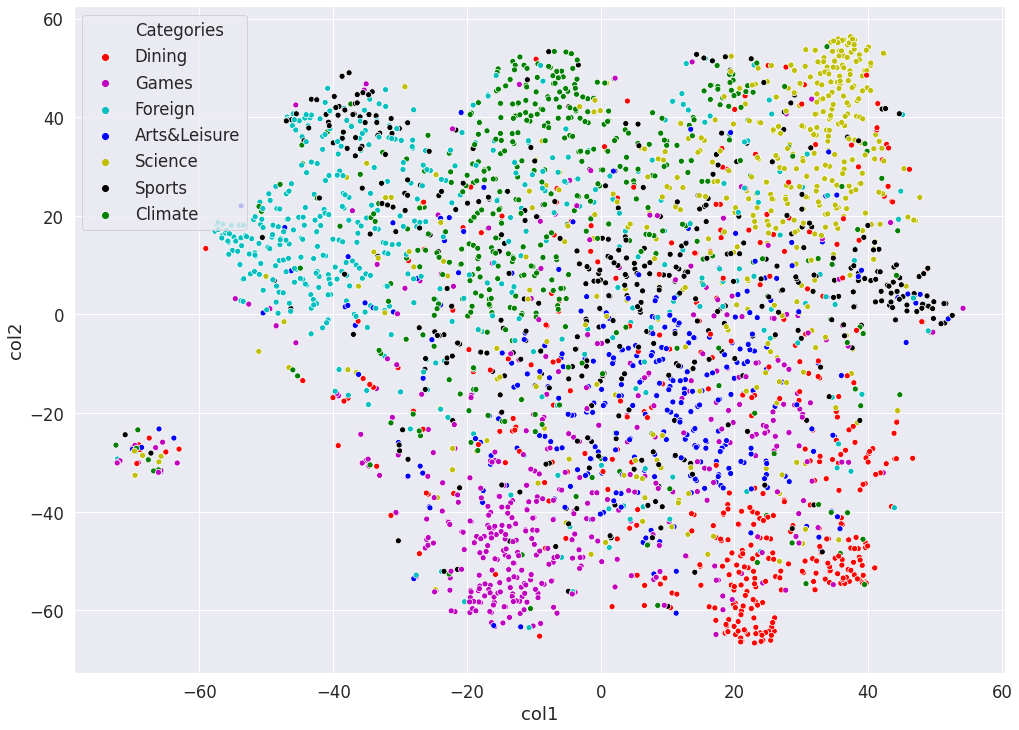

In [36]:
## WARNING THE COMPUTATION TIME ON COLAB IS LONG (5~10 minuts)
def cust_hott(p,q):
    return hott(p, q, C, threshold=None)

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
  
from sklearn.manifold import TSNE 
print("build TSNE")
Xtsne = pd.DataFrame(TSNE(n_components=2, metric = cust_hott,verbose=3).fit_transform(data['proportions']), columns = ['col1','col2'])
Xtsne['hue_'] = data['lib']


cols = [color for name, color in mcolors.BASE_COLORS.items()] 
colors = {}
for y_ in np.unique(data['y']) :
    colors[y_] = cols[y_+1]
colors={theme : c for theme, c in zip(np.unique(data["lib"]), colors.values())}

Xtsne.rename(columns={'hue_': 'Categories'}, inplace=True)

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(16.7, 12.27)
sns_plot = sns.scatterplot('col1','col2', data = Xtsne, hue = 'Categories', palette = colors, legend = "full")
sns_plot.set_title("t-SNE representation")
sns_plot.set(xlabel='', ylabel='')
fig_ = sns_plot.get_figure()


# LDA interpretation tools : interpretation of a 20 topics LDA on the 7 categories dataframe

In [42]:
data, y, lib= transform_dataframe(df3,balance=True)
y = y - 1

vocab1, embed_vocab1, bow_data1 = gen_data(data, embed_path)
print("stemming")
vocab, embed_vocab, bow_data = reduce_vocab(vocab1, embed_vocab1, bow_data1, embed_aggregate='mean') 
embeddings = np.array([embed_vocab[w] for w in vocab])


100% (400000 of 400000) |################| Elapsed Time: 0:00:21 Time:  0:00:21


extraction done in 23.029s.
stemming
The vocabulary has been reduced from 8752 words to 2122 words. This represents a reduction of 75.75 percent


In [44]:
tf_vectorizer = CountVectorizer(max_df=1, min_df=1, #cut off
                                max_features=None,
                                stop_words=None,
                                vocabulary={v : i for i,v in enumerate(vocab)}
                                ) # output is a sparse matrix
    

bow_data = sparse.csr_matrix(bow_data) 


print("computing LDA")
tic = time.time()

model = lda(n_components=20, max_iter=100, learning_method='online',learning_offset=50.,doc_topic_prior=1.,random_state=0,verbose=1)
model.fit(bow_data)
print("LDA fit done in %0.3fs." % (time.time() - tic))

prepared_data=pyLDAvis.sklearn.prepare(model, bow_data,tf_vectorizer)


computing LDA
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
ite

In [34]:
prepared_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.173414  0.002139       1        1  11.543632
3     -0.255949 -0.015861       2        1   7.732415
17     0.133307 -0.031546       3        1   4.945627
5     -0.088952  0.064478       4        1   4.878000
6      0.092667 -0.062281       5        1   4.707491
18    -0.203027 -0.104047       6        1   4.685204
11     0.089857 -0.063809       7        1   4.567238
19    -0.010369  0.245515       8        1   4.546931
13     0.107123  0.191733       9        1   4.487482
2     -0.023809  0.251164      10        1   4.467991
14     0.112728 -0.099351      11        1   4.457409
4      0.028158 -0.112247      12        1   4.445599
1      0.155379  0.016244      13        1   4.431615
0     -0.020283 -0.076539      14        1   4.422082
7      0.101338 -0.000145      15        1   4.373401
12    -0.024187 -0.044681      16        1   4.368495
9     -0.136672 -0.034682      17        1   4.259473
16     0.049262 -0.020221      18        1   4.242034
10    -0.034836 -0.006280      19        1   4.222267
8      0.101678 -0.099582      20        1   4.215614, topic_info=       Term        Freq       Total Category  logprob  loglift
919   trump  328.000000  328.000000  Default  30.0000  30.0000
851    mani  289.000000  289.000000  Default  29.0000  29.0000
3118   year  362.000000  362.000000  Default  28.0000  28.0000
1690   even  266.000000  266.000000  Default  27.0000  27.0000
451     see  280.000000  280.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
1357    set   31.761459   45.377932  Topic20  -4.6726   2.8096
1974    day   38.408339  184.469878  Topic20  -4.4826   1.5972
2799   read   32.806725  135.602839  Topic20  -4.6402   1.7473
3841   made   32.934114  178.982630  Topic20  -4.6364   1.4736
425    hope   31.205755  119.964585  Topic20  -4.6903   1.8198

[989 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2239      4  0.967514     2018
2155     20  0.975012     abil
1477     16  0.987995      abl
1986      7  0.943336  absolut
322       1  0.959666     abus
...     ...       ...      ...
3023     13  0.964086     york
2027      3  0.074017    young
2027      7  0.888203    young
2027     20  0.014803    young
3892      9  0.973315     your

[1709 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 4, 18, 6, 7, 19, 12, 20, 14, 3, 15, 5, 2, 1, 8, 13, 10, 17, 11, 9])

In [0]:
#Most characteristics words (some topics are difficult to interpret)

#easy to interpret
#Topic 1: drug anti depress 
#Topic 2: wa, israel palestine..
#Topic 3: first, guess, music, remember
#Topic 4: trump, go, give, pay 
#Topic 6: car, industry, business
#Topic 9: women, job, cherlead, men
#Topic 10: require, change, rule
#topic 14: play, player ,nfl, watch
#Topic 17: money, interest, need
#Topic 18: restaurant,well cream, ice, make,.., dessert

#less easy..
#topic 5: see, could, time, back
#Topic 7: read, comment, seem 
#Topic 8: want, know, live, think, better
#Topic 11: many, year, even
#Topic 12: use, much, less, always
#Topic 13: every, maybe food, good
#Topic 15: still, new, lot, work, story
#Topic 16: time, protect, world, said, .., state
#Topic 19: right, every, little
#Topic 20:love, puzzle, thank, great